**Author: Chatard Laura**

**Modification: 5/09/2024**

# Models test

This notebook is the 2nd part of the project. 

We are looking for a model that can predict whether a client’s loan application should be accepted or not.

# Import

In [47]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, confusion_matrix, make_scorer, fbeta_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from scipy.optimize import linear_sum_assignment

import lightgbm as lgb

import shap

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# MLflow
#!pip install --upgrade mlflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

import time

import json

In [2]:
# Import data
data = pd.read_csv('data.csv')

In [3]:
# Versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {LabelEncoder.__module__.split('.')[0]} {LabelEncoder.__module__.split('.')[1]}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"MLflow version: {mlflow.__version__}")

NumPy version: 1.24.3
Pandas version: 1.5.3
Scikit-learn version: sklearn preprocessing
Matplotlib version: 3.9.0
Seaborn version: 0.13.2
MLflow version: 2.16.0


# Fonctions

In [4]:
def conf_mat_transform(y_true, y_pred, class_labels, ax):
    """
    Transforms predicted labels to match true categories 
    by maximizing values on the diagonal of the confusion matrix.

    Args:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_labels: Labels for display
    - ax: Matplotlib axis for plotting

    Returns:
    - y_pred_transform: Transformed predicted labels to match true categories
    - df_cm: DataFrame of the transformed confusion matrix for display
    """
    # Compute the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Create the cost matrix to find the best match
    cost_matrix = -conf_mat  # Maximize the diagonal by minimizing the cost
    
    # Find the best permutation of columns to maximize diagonal values
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Reorder the columns of the confusion matrix based on the best permutation
    conf_mat_transformed = conf_mat[:, col_ind]
    
    # Create a mapping between clusters and true categories
    cluster_to_category = {i: col_ind[i] for i in range(len(col_ind))}
    
    # Transform predicted labels to match true categories
    y_pred_transform = np.array([cluster_to_category[cluster] for cluster in y_pred])
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(conf_mat_transformed, index=class_labels, columns=class_labels)
    
    # Plot the confusion matrix
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', ax=ax)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    return y_pred_transform, df_cm

# MLflow tracking

First, let's begin by discovering the universe of MLflow tracking. 
Here is the [documentation](https://mlflow.org/docs/latest/tracking.html) for the terms used by MLflow.

## Preprocessing

In [21]:
# Create a client MLflow
client = MlflowClient()

# List of all client
experiments = client.search_experiments()

# Print information
for experiment in experiments:
    print(f"ID: {experiment.experiment_id}, Name: {experiment.name}")

ID: 471647679769818948, Name: P7_exp_LightGBM
ID: 160787238110460711, Name: P7_exp_dummy_classifier
ID: 150774441229989355, Name: P7_exp_random_forest
ID: 228532471274446842, Name: P7_exp_linear_reg
ID: 0, Name: Default


We are working with 50% of datasets; without this parameter, the models don’t work.

In [44]:
data_sample = data.sample(frac=0.5)
data_sample.head()

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
15829,160002,285480,0,0,0,0,0,292500.0,553806.0,28404.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18404,46081,153386,0,1,0,0,0,135000.0,517788.0,18729.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
30173,156524,281432,0,0,0,0,0,166500.0,337500.0,16875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6852,275469,419245,0,1,0,0,1,180000.0,1057266.0,59035.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22286,166019,292469,0,1,1,0,1,216000.0,260640.0,28197.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Define the data
X = data_sample.drop(columns=['TARGET'])
y = data_sample['TARGET']

# Store feature names before transformation
feature_names = X.columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values: Impute missing values with the median and normalize the data
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We use the fact that false negatives and false positives have different costs to refine the model.

In [8]:
# Custom weighted score function to penalize false positives and false negatives differently
C_FN = 10  # Cost of a false negative
C_FP = 1   # Cost of a false positive

def weighted_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (C_FN * fn + C_FP * fp) / len(y_true)

# Define the class weights based on your costs
total_instances = len(X_train)
weight_0 = (total_instances / (2 * 1000)) * C_FN
weight_1 = (total_instances / (2 * 100)) * C_FP
class_weights = {0: weight_0, 1: weight_1}

## Choose metrics

The high accuracy may be due to the dataset being imbalanced. This [Kaggle](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset/notebook) resource helped me determine which metrics we should use.

![Metrics](info_metrics.png)

In this case, we know the cost of a false negative is ten times higher than the cost of a false positive.
For this project, the goal is to make predictions so that the bank can make the most advantageous decisions.

Other metrics :
- Time
- weighted score
- [Beta score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html)

## Test models

### Linear Regression

In [9]:
# ID 
P7_exp_linear_reg = "228532471274446842" 

2024/09/05 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.9174252275682705
Precision-Recall AUC: 0.17265298917244568
Weighted Score: 0.8257477243172952
Beta Score: 0.4911584516847674
Prediction time: 0.0035538673400878906 seconds


<Figure size 640x480 with 0 Axes>

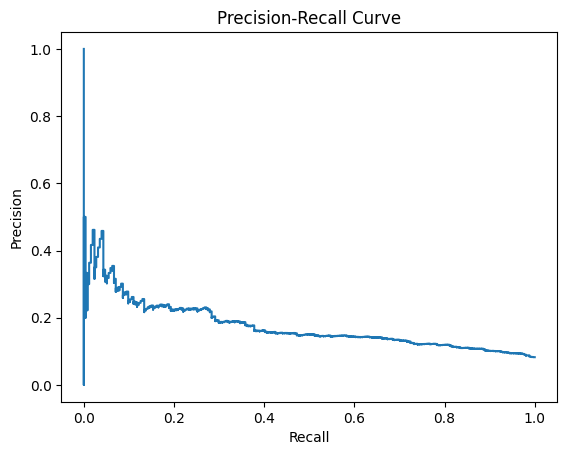

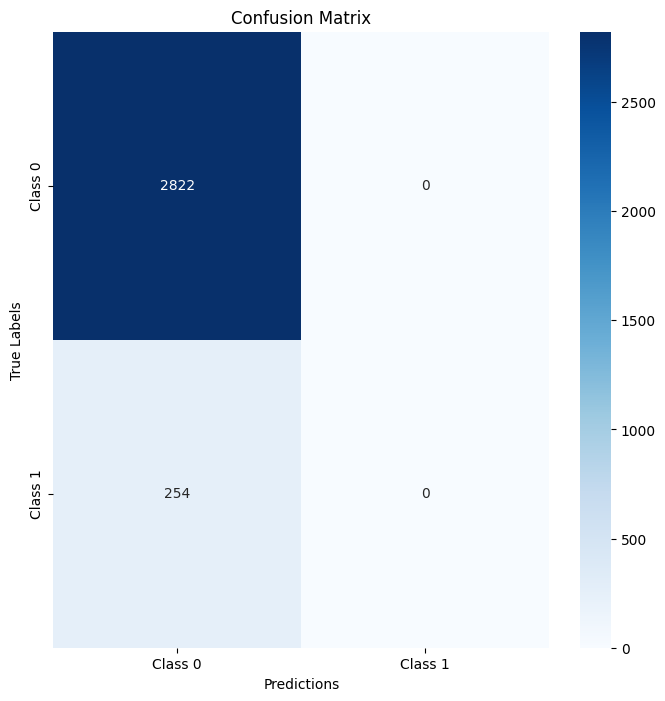

In [10]:
# Define the model and hyperparameters
C_value = 0.0001

# Start an MLflow run
with mlflow.start_run(run_name="LinearRegression_test", experiment_id=P7_exp_linear_reg):
    start_time = time.time()
    
    # Create and train the model
    log_reg = LogisticRegression(C=C_value, random_state=42)
    log_reg.fit(X_train, y_train)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Make predictions
    start_time = time.time()
    log_reg_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    threshold = 0.5
    predictions = (log_reg_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, _ = precision_recall_curve(y_test, log_reg_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, predictions)
    beta_score = fbeta_score(y_test, predictions, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("C", C_value)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, predictions, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the model in MLflow
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

### DummyClassifier

In [11]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_dummy_classifier')

# ID
P7_exp_dummy_classifier = "160787238110460711"

2024/09/05 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.8511053315994799
Precision-Recall AUC: 0.132249357971996
Weighted Score: 0.8218465539661899
Beta Score: 0.5068565938467922
Prediction time: 0.00028967857360839844 seconds


<Figure size 640x480 with 0 Axes>

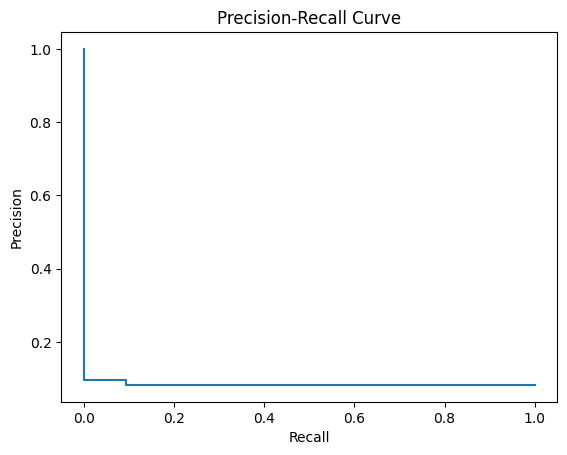

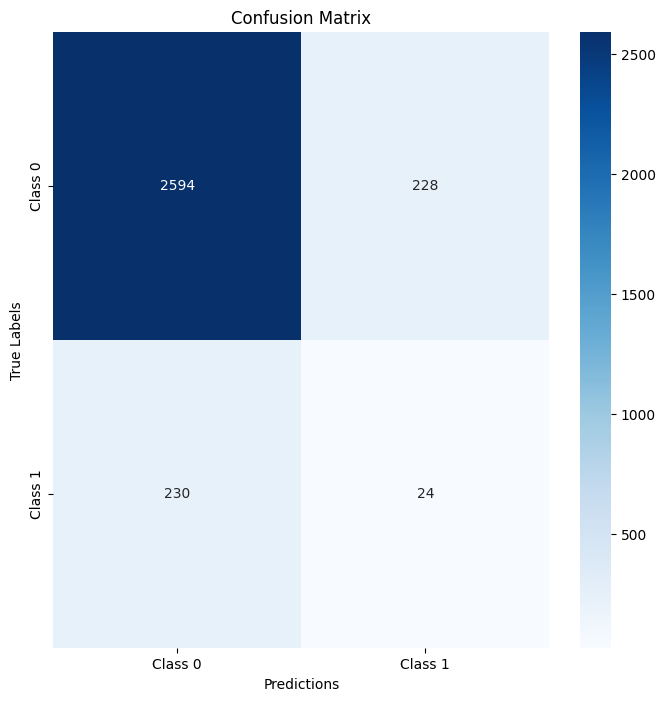

In [12]:
dummy_classifier = DummyClassifier(strategy='stratified', random_state=42)

# Define a pipeline with DummyClassifier
pipeline = Pipeline([
    ('classifier', dummy_classifier)
])


# Run the experiment with MLflow
with mlflow.start_run(run_name="DummyClassifier_experiment", experiment_id=P7_exp_dummy_classifier):
    start_time = time.time()

    # Fit the DummyClassifier
    pipeline.fit(X_train, y_train)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Evaluate the DummyClassifier on the test set
    start_time = time.time()
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    threshold = 0.3
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the model in MLflow
    mlflow.sklearn.log_model(pipeline, "dummy_model")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

## Models

### RandomForest

In [13]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_random_forest')

In [14]:
print("Distribution in y_train:")
print(pd.Series(y_train).value_counts())

print("Distribution in y_test:")
print(pd.Series(y_test).value_counts())

Distribution in y_train:
0    11313
1      987
Name: TARGET, dtype: int64
Distribution in y_test:
0    2822
1     254
Name: TARGET, dtype: int64


2024/09/05 13:13:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy: 0.8875162548764629
Precision-Recall AUC: 0.17680954289002526
Weighted Score: 0.7327698309492848
Beta Score: 0.5617269438394863
Prediction time: 0.03624224662780762 seconds


<Figure size 640x480 with 0 Axes>

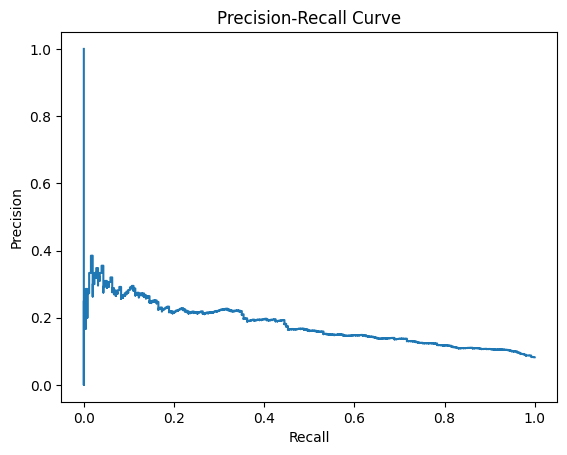

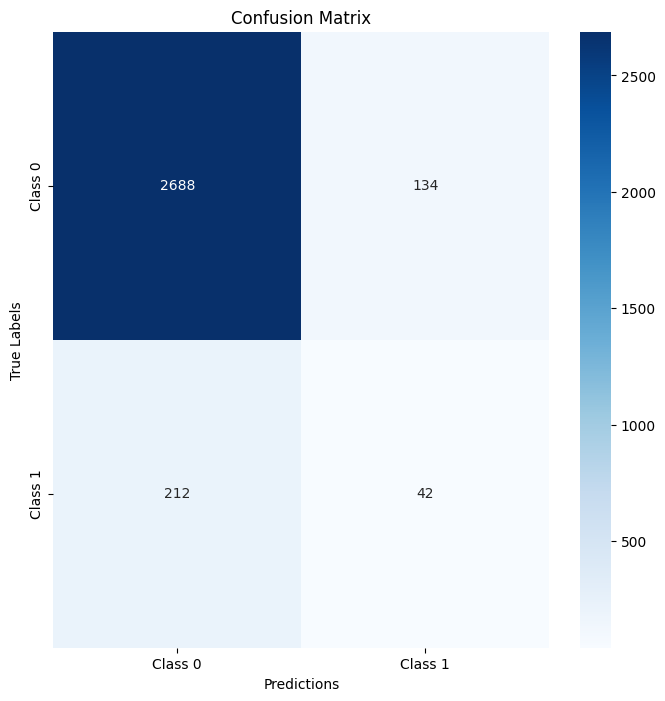

[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80973
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80973
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80792
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 662
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Info] Number of positive: 789, number of negative: 9051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.382116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80967
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 662
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80845
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 663
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Info] Number of positive: 789, number of negative: 9051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80909
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 664
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 789, number of negative: 9051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80909
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080183 -> initscore=-2.439864
[LightGBM] [Info] Start training from score -2.439864
[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80792
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 662
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Info

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 790, number of negative: 9050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80973
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 664
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080285 -> initscore=-2.438487
[LightGBM] [Info] Start training from score -2.438487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 789, number of negative: 9051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

In [25]:
# Execute the experiment with MLflow
with mlflow.start_run(run_name="RandomForest_gridsearch_balanced", experiment_id=150774441229989355):
    start_time = time.time()
    
    # Define a pipeline and grid search
    pipeline = Pipeline([
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__bootstrap': [True, False]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=0)

    # Run GridSearchCV to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    start_time = time.time()
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    threshold = 0.3
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("best_n_estimators", grid_search.best_params_['classifier__n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['classifier__max_depth'])
    mlflow.log_param("best_min_samples_split", grid_search.best_params_['classifier__min_samples_split'])
    mlflow.log_param("best_min_samples_leaf", grid_search.best_params_['classifier__min_samples_leaf'])
    mlflow.log_param("best_bootstrap", grid_search.best_params_['classifier__bootstrap'])

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the best model in MLflow
    mlflow.sklearn.log_model(best_model, "best_model")

    # Save the best parameters as an artifact
    with open("best_model_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))
    mlflow.log_artifact("best_model_params.txt")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Best model parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

### LightBoosting

After testing Random Forest, we will test the LightBoosting model. We chose it for its speed, which is an important business characteristic.

In [22]:
# Create a new experiment and get its ID
#experiment_id = mlflow.create_experiment('P7_exp_LightGBM')

# ID
P7_exp_LightGBM = "471647679769818948"

#Calculate scale_pos_weight
#Assuming y_train is a pandas Series or can be converted to one
y_train_series = pd.Series(y_train)

#Number of negative samples (class label 0à
num_negative_samples = (y_train_series == 0).sum()

#Number of positive samples
num_positive_samples = (y_train_series == 1).sum()
scale_pos_weight = num_negative_samples / num_positive_samples

#Define the LightGBM model with scale_pos_weight
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight)

In [76]:
# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(class_weight='balanced', objective='binary', metric='binary_logloss', random_state=42)

# Define the pipeline and grid search
pipeline = Pipeline([
    ('classifier', lgb_model)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [31, 63]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=0)

[LightGBM] [Info] Number of positive: 1049, number of negative: 11251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82940
[LightGBM] [Info] Number of data points in the train set: 12300, number of used features: 676
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2024/09/05 22:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 20, 'classifier__n_estimators': 200, 'classifier__num_leaves': 63}
Accuracy: 0.9161248374512354
Precision-Recall AUC: 0.20584505296740507
Weighted Score: 0.7480494148244473
Beta Score: 0.5224757159125727
Prediction time: 0.026659250259399414 seconds


<Figure size 640x480 with 0 Axes>

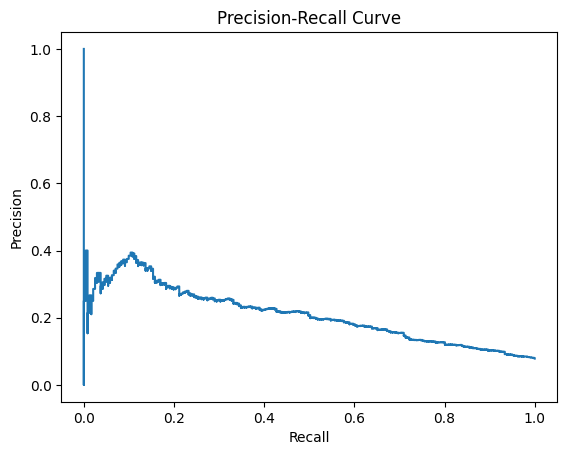

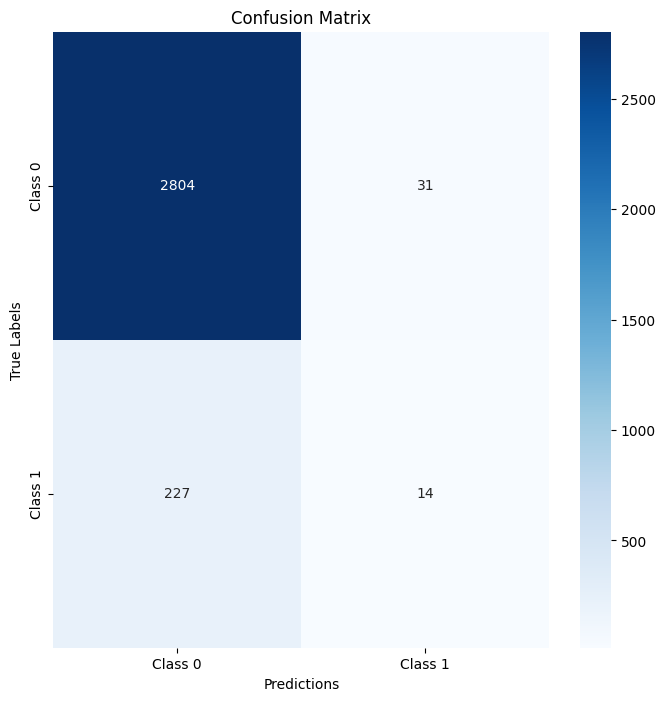

[LightGBM] [Info] Number of positive: 840, number of negative: 9000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80958
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 665
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 840, number of negative: 9000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80958
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 665
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80807
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80735
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 665
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80766
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 667
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.259529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80827
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 666
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 840, number of negative: 9000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80958
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 665
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 840, number of negative: 9000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80958
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 665
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80827
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 666
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 839, number of negative: 9001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80807
[LightGBM] [Info] Number of data points in the train set: 9840, number of used features: 669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Light

In [77]:
# Execute the experiment with MLflow
with mlflow.start_run(run_name="LightGBM_class_weights_balanced", experiment_id=P7_exp_LightGBM):
    start_time = time.time()

    # Run GridSearchCV to find the best hyperparameters
    grid_search.fit(X_train, y_train)

    # Log training time
    training_time = time.time() - start_time
    mlflow.log_metric("training_time", training_time)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    start_time = time.time()
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    threshold = 0.5
    y_pred = (y_pred_proba > threshold).astype(int)
    prediction_time = time.time() - start_time
    mlflow.log_metric("prediction_time", prediction_time)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    weighted_score_val = weighted_score(y_test, y_pred)
    beta_score = fbeta_score(y_test, y_pred, average='macro', beta=2)

    # Log parameters and metrics in MLflow
    mlflow.log_param("best_n_estimators", grid_search.best_params_['classifier__n_estimators'])
    mlflow.log_param("best_max_depth", grid_search.best_params_['classifier__max_depth'])
    mlflow.log_param("best_learning_rate", grid_search.best_params_['classifier__learning_rate'])
    mlflow.log_param("best_num_leaves", grid_search.best_params_['classifier__num_leaves'])

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_recall_auc", pr_auc)
    mlflow.log_metric("weighted_score", weighted_score_val)
    mlflow.log_metric("beta_score", beta_score)

    # Save the precision-recall curve as an artifact
    plt.figure()
    PrecisionRecallDisplay(precision, recall).plot()
    plt.title("Precision-Recall Curve")
    plt.savefig("precision_recall_curve.png")
    mlflow.log_artifact("precision_recall_curve.png")

    # Save the confusion matrix as an artifact using the custom function
    fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_transform, df_cm = conf_mat_transform(y_test, y_pred, class_labels=['Class 0', 'Class 1'], ax=ax)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the best model in MLflow
    mlflow.sklearn.log_model(best_model, "best_model")

    # Save the best parameters as an artifact
    with open("best_model_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))
    mlflow.log_artifact("best_model_params.txt")

    # Save the metrics as a JSON file
    metrics = {
        "accuracy": accuracy,
        "precision_recall_auc": pr_auc,
        "weighted_score": weighted_score_val,
        "beta_score": beta_score,
        "training_time": training_time,
        "prediction_time": prediction_time
    }

    with open("metrics.json", "w") as f:
        json.dump(metrics, f)
    mlflow.log_artifact("metrics.json")

    # Print the results
    print(f"Best model parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision-Recall AUC: {pr_auc}")
    print(f"Weighted Score: {weighted_score_val}")
    print(f"Beta Score: {beta_score}")
    print(f"Prediction time: {prediction_time} seconds")

# Features importance

 99%|===================| 3042/3076 [00:17<00:00]        

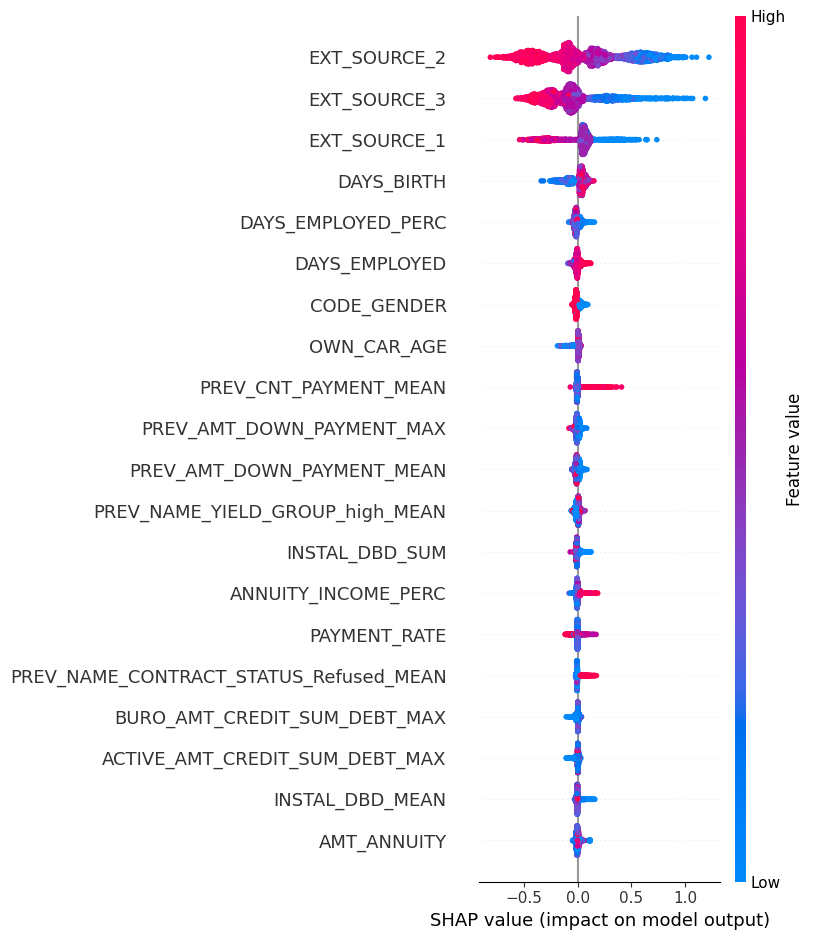

In [61]:
# If you have a pipeline, extract the model
lgb_model = best_model.named_steps['classifier']

# Create a SHAP explainer using the raw data before transformation
explainer = shap.Explainer(lgb_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot (global view of feature importances)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

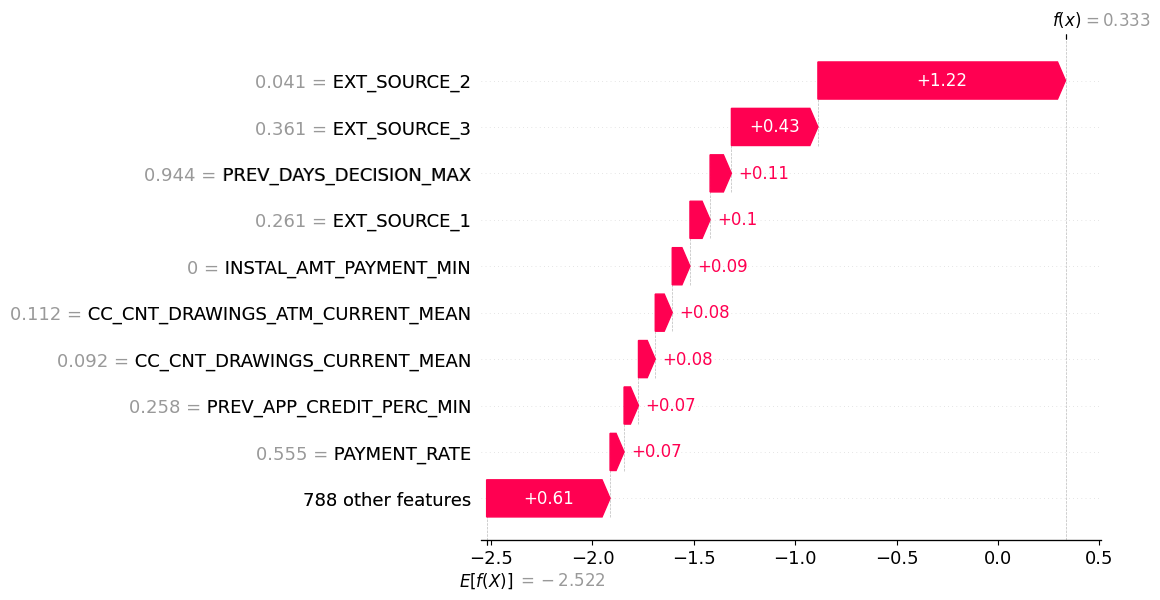

In [67]:
# Select a specific client's data 
client_index = 0  # Change this to target a specific client
client_data = X_test[client_index:client_index+1]

# Get SHAP values for this specific client
shap_values_client = explainer(client_data)

# Pass feature names directly to the SHAP values for visualization
shap_values_client.data = client_data  # Actual values for the client
shap_values_client.feature_names = feature_names  # Attach feature names

# Waterfall plot for a single client
shap.plots.waterfall(shap_values_client[0])

Now, we are wondering if the important features vary depending on the prediction.

In [71]:
# Get the indices of the different cases
false_positives = (y_pred == 1) & (y_test == 0)
false_negatives = (y_pred == 0) & (y_test == 1)
true_positives = (y_pred == 1) & (y_test == 1)
true_negatives = (y_pred == 0) & (y_test == 0)

# Helper function to safely get the index
def get_first_index(case, case_name):
    if case.sum() > 0:  # Check if there are any instances of this case
        return case[case].index[0]  # Return the first index where the condition is True
    else:
        print(f"No instances of {case_name} found.")
        return None

# Get the index for each case
fp_index = get_first_index(false_positives, "False Positive")
fn_index = get_first_index(false_negatives, "False Negative")
tp_index = get_first_index(true_positives, "True Positive")
tn_index = get_first_index(true_negatives, "True Negative")

# Now, generate SHAP plots only for cases that have valid indices
for index, case in zip([fp_index, fn_index, tp_index, tn_index], 
                       ["False Positive", "False Negative", "True Positive", "True Negative"]):
    if index is not None:  # Ensure that the case has a valid index
        client_data = X_test[index:index+1]
        shap_values_client = explainer(client_data)
        
        # Pass feature names directly to the SHAP values for visualization
        shap_values_client.data = client_data  # Actual values for the client
        shap_values_client.feature_names = feature_names  # Attach feature names
        
        # Waterfall plot for each client
        print(f"SHAP Waterfall plot for {case} (Client Index: {index})")
        shap.plots.waterfall(shap_values_client[0])

No instances of False Positive found.


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# List of client indices
client_indices = {
    'False Positive': fp_index,
    'False Negative': fn_index,
    'True Positive': tp_index,
    'True Negative': tn_index
}

# Loop over each category and plot the local feature importance using SHAP
for label, client_index in client_indices.items():
    print(f"Generating SHAP Waterfall plot for {label} client...")

    # Select the client's data
    client_data = X_test[client_index:client_index+1]

    # Get SHAP values for this specific client
    shap_values_client = explainer(client_data)

    # Set the feature names
    shap_values_client.feature_names = feature_names

    # Waterfall plot for the specific client
    shap.plots.waterfall(shap_values_client[0])